In [2]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
split = 0

In [3]:
eval_file = f"facebase/results/Adience_256x256_resnet50_imagenet_my_dldl_v2_noisy_train_val_0.4_3/split{split}/evaluation.pt"
clean_data_file = f"facebase/data/Adience_256x256_resnet50_imagenet_dldl_v2_clean/data_split{split}.csv"
noisy_data_file = f"facebase/data/Adience_256x256_resnet50_imagenet_noisy_dldl_v2/data_split{split}.csv"

In [4]:
means_file = f"facebase/results/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_3/split{split}/mean_history.json"
sigmas_file = f"facebase/results/Adience_256x256_resnet50_imagenet_noisy_dldl_v2_3/split{split}/sigma_history.json"

In [5]:
noisy_df = pd.read_csv(noisy_data_file, header=None)
clean_df = pd.read_csv(clean_data_file, header=None)
eval = torch.load(eval_file)

In [6]:
with open(means_file, 'r') as file:
    last_means = json.load(file)

with open(sigmas_file, 'r') as file:
    last_sigmas = json.load(file)

means = {int(key): value[-1] for key, value in last_means.items()}
sigmas = {int(key): value[-1] for key, value in last_sigmas.items()}

In [7]:
eval.keys()

dict_keys(['config', 'split', 'error', 'log_history', 'posterior', 'true_label', 'predicted_label', 'id', 'folder'])

In [16]:
df = noisy_df.copy()
df['clean_label'] = clean_df[3]
df['predicted_label'] = eval['predicted_label']['age']
df['preds'] = list(np.array(F.softmax(torch.tensor(eval['posterior']['age']), dim=1)))
df.rename(columns={0: 'id', 1:'img_path', 2: 'folder', 3: 'noisy_label'}, inplace=True)

# df['max_prob'] = df['preds'].apply(np.max)  # Calculate mean
# df['variance'] = df['preds'].apply(np.var)  # Calculate variance
df['mean'] = df['id'].map(means)
df['sigma'] = df['id'].map(sigmas)

pd.set_option('display.max_colwidth', None) # Show full content of each cell

df.to_csv("yoyo.csv")

In [17]:
df_splits = {
    'trn_df': df[df['folder'] == 0],
    'val_df': df[df['folder'] == 1],
    'tst_df': df[df['folder'] == 2]
}

In [18]:
for split, df in df_splits.items():
    df['label_diff'] = (df['clean_label'] - df['noisy_label']).apply(np.abs)

In [19]:
df_splits['trn_df']['label_diff'].mean()

0.8832389994522549

In [20]:
for split, df in df_splits.items():
    df['correct_diff'] = (df['clean_label'] - df['mean']).apply(np.abs)

In [21]:
df_splits['trn_df']['correct_diff'].mean()

0.4618978915448327

In [11]:
def plot_hist(df, column, title):
    ax = df[column].hist(bins=8, edgecolor='black')
    counts, bin_edges, _ = ax.hist(df[column], bins=8, edgecolor='black')
    total = len(df[column])
    ratios = counts / total
    for i in range(len(counts)):
        ax.text(
            (bin_edges[i] + bin_edges[i+1]) / 2,  # x-position: center of the bar
            counts[i],                            # y-position: top of the bar
            f'{int(counts[i])}',                   # Text: ratio formatted to 2 decimal places
            ha='center', va='bottom'              # Horizontal and vertical alignment
        )
    plt.title(title)
    plt.show()

In [12]:
for split, df in df_splits.items():
    print(split)
    print((df['clean_label'].value_counts()))
    print()

trn_df
clean_label
4    3066
0    1857
2    1455
1    1332
5    1315
3     947
7     497
6     485
Name: count, dtype: int64

val_df
clean_label
4    970
5    523
2    497
3    468
1    238
0    151
7    118
6    104
Name: count, dtype: int64

tst_df
clean_label
4    1059
1     570
5     502
0     483
2     340
7     257
6     241
3     227
Name: count, dtype: int64



In [13]:
for split, df in df_splits.items():
    print(split)
    print((df['label_diff'].value_counts()))
    print()

trn_df
label_diff
0    6467
1    1722
2    1303
3     807
4     430
5     159
6      51
7      15
Name: count, dtype: int64

val_df
label_diff
0    1703
1     508
2     425
3     286
4     103
5      37
6       7
Name: count, dtype: int64

tst_df
label_diff
0    3679
Name: count, dtype: int64



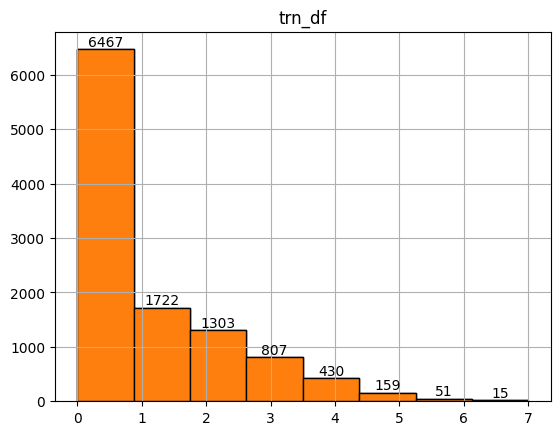

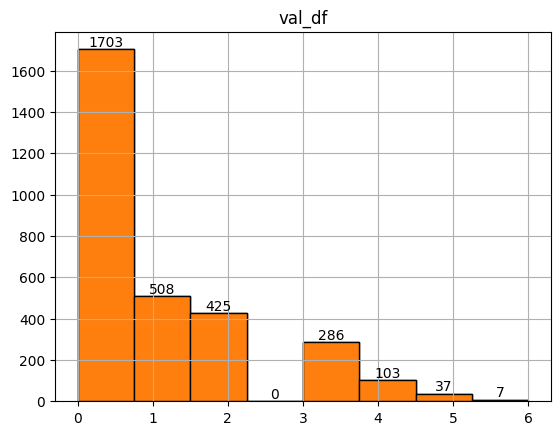

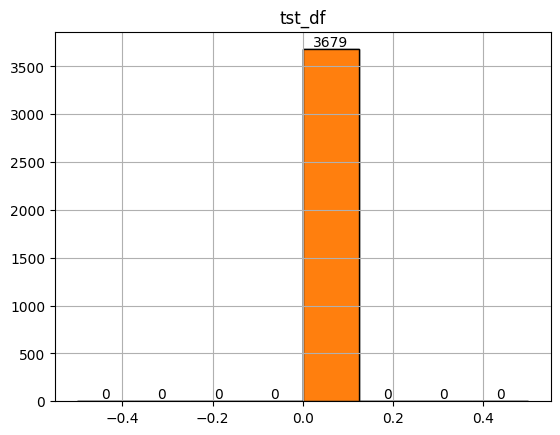

In [14]:
for split, df in df_splits.items():
    plot_hist(df, 'label_diff', split)

In [ ]:
0    0.362061
1    0.414570   
2    0.551423   1
3    0.691106   1
4    0.998715   1
5    1.357708   1
6    1.132941   1
7    1.663948   1

0    0.349312
1    0.408827
2    0.554873
3    0.732342
4    1.060465
5    1.402516
6    1.274510
7    1.800000

0    0.500850
1    0.473868
2    0.612433
3    0.631970
4    0.795349
5    0.874214
6    0.980392
7    1.400000

In [15]:
for split, df in df_splits.items():
    print(split)
    # Compute absolute differences
    df['abs_diff_predicted_noisy'] = abs(df['predicted_label'] - df['noisy_label'])
    df['abs_diff_predicted_clean'] = abs(df['predicted_label'] - df['clean_label'])

    # Group by label_diff and calculate mean
    mean_diff_noisy = df.groupby('label_diff')['abs_diff_predicted_noisy'].mean()
    mean_diff_clean = df.groupby('label_diff')['abs_diff_predicted_clean'].mean()

    # Display the results
    print("Mean Absolute Difference (Predicted vs Noisy) per label_diff:")
    print(mean_diff_noisy)

    print("\nMean Absolute Difference (Predicted vs Clean) per label_diff:")
    print(mean_diff_clean)
    print()

trn_df
Mean Absolute Difference (Predicted vs Noisy) per label_diff:
label_diff
0    0.500850
1    0.838560
2    1.630084
3    2.501859
4    3.269767
5    4.163522
6    5.019608
7    5.600000
Name: abs_diff_predicted_noisy, dtype: float64

Mean Absolute Difference (Predicted vs Clean) per label_diff:
label_diff
0    0.500850
1    0.473868
2    0.612433
3    0.631970
4    0.795349
5    0.874214
6    0.980392
7    1.400000
Name: abs_diff_predicted_clean, dtype: float64

val_df
Mean Absolute Difference (Predicted vs Noisy) per label_diff:
label_diff
0    0.682913
1    1.053150
2    1.971765
3    2.923077
4    3.776699
5    4.702703
6    4.714286
Name: abs_diff_predicted_noisy, dtype: float64

Mean Absolute Difference (Predicted vs Clean) per label_diff:
label_diff
0    0.682913
1    0.635827
2    0.640000
3    0.587413
4    0.495146
5    0.729730
6    1.285714
Name: abs_diff_predicted_clean, dtype: float64

tst_df
Mean Absolute Difference (Predicted vs Noisy) per label_diff:
label_diff
0 

In [23]:
for split, df in df_splits.items():
    print(split)
    # Compute absolute differences
    df['abs_diff_mean_noisy'] = abs(df['mean'] - df['noisy_label'])
    df['abs_diff_mean_clean'] = abs(df['mean'] - df['clean_label'])

    # Group by label_diff and calculate mean
    mean_diff_noisy = df.groupby('label_diff')['abs_diff_mean_noisy'].mean()
    mean_diff_clean = df.groupby('label_diff')['abs_diff_mean_clean'].mean()

    # Display the results
    print("Mean Absolute Difference (Mean vs Noisy) per label_diff:")
    print(mean_diff_noisy)

    print("\nMean Absolute Difference (Mean vs Clean) per label_diff:")
    print(mean_diff_clean)
    print()
    break

trn_df
Mean Absolute Difference (Mean vs Noisy) per label_diff:
label_diff
0    0.362061
1    0.788932
2    1.543787
3    2.333332
4    3.001891
5    3.642292
6    4.867059
7    5.336052
Name: abs_diff_mean_noisy, dtype: float64

Mean Absolute Difference (Mean vs Clean) per label_diff:
label_diff
0    0.362061
1    0.414570
2    0.551423
3    0.691106
4    0.998715
5    1.357708
6    1.132941
7    1.663948
Name: abs_diff_mean_clean, dtype: float64



In [14]:
nr_classes = 8
batch_size = 2
labels = torch.tensor([2, 5])
sigma = 1
class_labels = torch.arange(0, nr_classes)
class_labels = class_labels.unsqueeze(0).expand(batch_size, -1)  # Broadcast to batch size

# Broadcast ground-truth labels to match the shape of class_labels
broadcast_labels = labels.unsqueeze(1).expand(-1, nr_classes)

# Generate the ground-truth label distribution using a Gaussian distribution
label_distributions = torch.exp(-((class_labels - broadcast_labels) ** 2) / (2 * sigma ** 2))
label_distributions = label_distributions / label_distributions.sum(dim=1, keepdim=True)  # Normalize

print(label_distributions)

tensor([[5.4239e-02, 2.4308e-01, 4.0077e-01, 2.4308e-01, 5.4239e-02, 4.4522e-03,
         1.3444e-04, 1.4935e-06],
        [1.4935e-06, 1.3444e-04, 4.4522e-03, 5.4239e-02, 2.4308e-01, 4.0077e-01,
         2.4308e-01, 5.4239e-02]])
